# Evaluating RAG Parameters Using tvalmetrics

* **Tonic Validate Metrics Gitbub Repo**: https://github.com/TonicAI/tvalmetrics
* **Tonic Validate Documentation**: https://docs.tonic.ai/validate/
* **Tonic Validate Sign Up**: https://validate.tonic.ai/signup (platform for developing RAG applications)

In this guide we

* 🔨 Build RAG query engines using [LlamaIndex](https://github.com/run-llama/llama_index) with varied chunk sizes and number of retrieved context chunks. In the spirit of Andrej Karpathy's [Paul Graham generator](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), our RAG query engines are built on a dataset of 6 Paul Graham essays about startup founders.
* ➡️ Generate responses to 10 questions about the Paul Graham essays for each query engine.
* 📏 Evaluate the responses of each query engine using [tvalmetrics](https://github.com/TonicAI/tvalmetrics).
* ✏️ Analyze how each Tonic Validate metric varies with chunk size and number of retrieved context chunks.
* 💡 Use Tonic Validate metrics to determine the best combination of chunk size and number of retrieved context chunks.

# Overview

Retrieval Augmented Generate (RAG) is one of the most popular LLM applications in the current moment LLMs are having. There are many great [explanations](https://www.tonic.ai/blog/what-is-retrieval-augmented-generation-the-benefits-of-implementing-rag-in-using-llms) out there of what RAG is, why it's great, and how to [implement it](https://github.com/ray-project/llm-applications/blob/main/notebooks/rag.ipynb). This notebook is about how to measure the performance of a RAG application, answering the questions "Is my RAG application responding to questions how I want it to?" and "If I change these RAG parameters, how does the quality of my RAG applications responses change?"

Earlier this year, at [Tonic](https://www.tonic.ai/), we built a RAG chatbot to allow Tonic employees to intuitively interact with our internal documents. We found during development that, while it is often easy to build compelling LLM demos using cherry-picked examples, robust application performance depends heavily on the careful tuning of many RAG parameters and pipeline components. Tuning these parameters without metrics or evaluations is an impossible task, and the tooling for managing these experiments did not yet exist. So we developed a standard evaluation framework for measuring the accuracy of responses from a RAG application that follows three steps:

1. Create a benchmark dataset of questions and answers to test the RAG application with.
2. Measure the accuracy of the RAG application’s natural language responses by using LLMs to derive scores from different aspects of the responses.
3. For each change to the architecture of the RAG application, obtain new responses to the questions in the benchmark dataset and observe how the metrics change.

Defining the metrics with which to evaluate the RAG application was a challenge, however. The challenge is two-fold: 

1. **A RAG application is built of many moving pieces.** Any small change to one of these pieces can have a significant impact on the answers returned by the application.
2. **It is difficult to evaluate natural language responses.** Unlike numeric predictions in a supervised machine learning task, there aren’t well-defined mathematical metrics for measuring the accuracy of natural language responses.

The steps of a typical RAG application are:

1. The user asks a question.
2. The application retrieves contextual information relevant to the question from the documents database, called the retrieved context.
3. The application augments the user’s question to prompt an LLM.
4. The LLM generates an answer to the question, which is returned to the user.

In this flow, the retrieved context and returned answer are the two outputs of the RAG application that need to be evaluated and improved. In order to evaluate the natural language outputs, Tonic Validate Metrics (`tvalmetrics`) uses an LLM evaluator (i.e. GPT-4) to score these outputs by comparing them to the question asked and the correct answer (what the answer should be). The LLM evaluator is asked the following questions for each metric to assess each aspect of the RAG application:

* **Answer similarity score**: How well does the returned answer match the correct answer?
* **Retrieval precision**: Is the retrieved context relevant to answer the question?
* **Augmentation precision**: Is the relevant retrieved context included in the LLM prompt?
* **Augmentation accuracy**: How much of the retrieved context is in the answer?
* **Answer consistency**: Does the answer contain information that is not derived from the retrieved context?

In this notebook we use `tvalmetrics` to compute examples of these metrics and show how they vary with the RAG parameters chunk size and number of retrieved context vectors, ultimately showing how to use `tvalmetrics` to determine the best choice of RAG parameters for your RAG system.


# Set Up

We use some Python standard library packages, the usual data anlysis packages (`pandas`, `numpy`, `matplotlib`), and then `llama_index` and `tvalmetrics`.

In [1]:
from typing import List, Dict, Union, Any
import json
import os
import logging
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from llama_index import ServiceContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.retrievers import VectorIndexRetriever
from llama_index.query_engine import RetrieverQueryEngine

from tvalmetrics import RagScoresCalculator

logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s", level=logging.INFO
)
logger = logging.getLogger()

We load the benchmark question and answer list from a json file. This list consists of 10 simple questions about the Paul Graham essays with 10 reference answers. For each question, the answer is in one block of text from a Paul Graham essay.

In [2]:
with open("question_and_answer_list.json", "r") as f:
    question_and_answer_list = json.load(f)

question_and_answer_list = [dict(question=x["question"], answer=x["answer"]) for x in question_and_answer_list]

question_and_answer_list

[{'question': 'What makes Sam Altman a good founder?',
  'answer': 'He has a great force of will.'},
 {'question': 'When was the essay "Five Founders" written?',
  'answer': 'April 2009'},
 {'question': 'When does the most dramatic growth happen for a startup?',
  'answer': 'When the startup only has three or four people.'},
 {'question': 'What is the problem with business culture versus start up culture with respect to productivity?',
  'answer': "In business culture, energy is expended on outward appearance to the detriment of productivity, while in startup culture there is no value of appearance it's all about productivity."},
 {'question': "What's the single biggest thing the government could do to increase the number of startups in this country?",
  'answer': 'Establish a new class of visa for startup founders.'},
 {'question': 'How could one create a rigorous government definition of what a startup is to categorize whether a business is a startup?',
  'answer': 'One could define 

# Build Query Engines and Get the RAG Responses

For each section, we start off with some auxilliary helper functions that are used to do the computations in the section.

In [3]:
def get_query_engine(chunk_size: int, similarity_top_k: int) -> RetrieverQueryEngine:
    
    documents = SimpleDirectoryReader("./paul_graham_essays").load_data()
    if chunk_size > 20:
        service_context = ServiceContext.from_defaults(chunk_size=chunk_size)
    else:
        service_context = ServiceContext.from_defaults(chunk_size=chunk_size, chunk_overlap=10)
    index = VectorStoreIndex.from_documents(documents, service_context=service_context)
    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=similarity_top_k
    )
    query_engine = RetrieverQueryEngine(retriever=retriever)
    
    return query_engine

def ask_questions_and_record_responses(
    question_and_answer_list: List[Dict[str, str]], query_engine: RetrieverQueryEngine
) -> List[Dict[str, Union[str, List[str]]]]:
    response_dict_list = []
    
    for q_and_a in question_and_answer_list:
        question = q_and_a["question"]
        reference_answer = q_and_a["answer"]
        response = query_engine.query(question)
        llm_answer = response.response
        retrieved_context = [source_node.node.text for source_node in response.source_nodes]
        
        response_dict_list.append(
            {
                "question": question,
                "reference_answer": reference_answer,
                "llm_answer": llm_answer,
                "retrieved_context": retrieved_context
            }
        )
    
    return response_dict_list

def make_rag_response_path(chunk_size: int, similarity_top_k: int, save_dir: str) -> str:
    filename = f"rag_responses_chunk_size_{chunk_size}_similarity_top_k_{similarity_top_k}.json"
    return os.path.join(save_dir, filename)

def load_already_saved_json(step_save_path: str) -> Any:
        logger.info(f"already saved {step_save_path}, loading and continuing")
        with open(step_save_path, "r") as f:
             loaded_json = json.load(f)
        return loaded_json

LlamaIndex is used to generate RAG responses for a sweep over values for the RAG parameters of chunk size and number of retrieved context chunks. A new RAG query engine is made for each pair of parameters. Then, the responses for each of the 10 questions in our benchmark question list is recorded in a json file. If the json file already exists (as is the case in this github repo), then the json file is loaded.

For LlamaIndex, the number retrieved chunks parameter is called `similarity_top_k_list`. We use this same name for the variable in our code. We also refer to the number of retrieved chunks as the letter `k`.

The total context window value is set as 3964, which is less than gpt-3.5-turbo's (the LLM powering the RAG system) context window length of 4097. The 3964 value is the value used for the context chunks put into the prompt during the RAG process, leaving at least 4097 - 3964 = 133 tokens for the question and RAG prompt template.

The chunk size size varies from 16 to 2048, and the number of context chunks retrieved varies from 1 to 32. For both parameters a base 2 exponential scale is used to vary the parameter. Only pairs of parameters whose product is less than the total context window value of 3964 are used.

In [4]:
chunk_size_list = [16, 32, 64, 128, 256, 512, 1024, 2048]

similarity_top_k_list = [1, 2, 4, 8, 16, 32]

context_window = 3964

sweep_response_list = []

save_dir = "sweep_responses"
if not (os.path.exists(save_dir) and os.path.isdir(save_dir)):
    os.makedirs(save_dir)

for chunk_size, similarity_top_k in product(chunk_size_list, similarity_top_k_list):
    
    if chunk_size * similarity_top_k > context_window:
        continue
        
    step_save_path = make_rag_response_path(chunk_size, similarity_top_k, save_dir) 
    if os.path.isfile(step_save_path):
        sweep_response_list.append(load_already_saved_json(step_save_path))
        continue

    query_engine = get_query_engine(chunk_size, similarity_top_k)
    
    response_dict_list = ask_questions_and_record_responses(question_and_answer_list, query_engine)
    
    rag_response = {
            "chunk_size": chunk_size,
            "similarity_top_k": similarity_top_k,
            "response_dict_list": response_dict_list
    }
    sweep_response_list.append(rag_response)
    
    with open(step_save_path, "w") as f:
        json.dump(rag_response, f)
    logger.info(f"saved {step_save_path}")

2023-10-31 11:23:27,308 [INFO] already saved sweep_responses/rag_responses_chunk_size_16_similarity_top_k_1.json, loading and continuing
2023-10-31 11:23:27,309 [INFO] already saved sweep_responses/rag_responses_chunk_size_16_similarity_top_k_2.json, loading and continuing
2023-10-31 11:23:27,311 [INFO] already saved sweep_responses/rag_responses_chunk_size_16_similarity_top_k_4.json, loading and continuing
2023-10-31 11:23:27,312 [INFO] already saved sweep_responses/rag_responses_chunk_size_16_similarity_top_k_8.json, loading and continuing
2023-10-31 11:23:27,313 [INFO] already saved sweep_responses/rag_responses_chunk_size_16_similarity_top_k_16.json, loading and continuing
2023-10-31 11:23:27,314 [INFO] already saved sweep_responses/rag_responses_chunk_size_16_similarity_top_k_32.json, loading and continuing
2023-10-31 11:23:27,315 [INFO] already saved sweep_responses/rag_responses_chunk_size_32_similarity_top_k_1.json, loading and continuing
2023-10-31 11:23:27,316 [INFO] already 

# Score RAG Responses

In [5]:
def calculate_rag_scores(sweep_response: Any, score_calculator: RagScoresCalculator) -> Any:

    response_dict_list = sweep_response["response_dict_list"]
    question_list = [x["question"] for x in response_dict_list]
    reference_answer_list = [x["reference_answer"] for x in response_dict_list]
    llm_answer_list = [x["llm_answer"] for x in response_dict_list]
    retrieved_context_list = [x["retrieved_context"] for x in response_dict_list] 
    
    batch_scores = score_calculator.score_batch(
        question_list,
        reference_answer_list,
        llm_answer_list,
        retrieved_context_list
    )
    
    return batch_scores
    
def make_scores_results_dict(sweep_response: Any, batch_scores: Any) -> Any:
    mean_scores = batch_scores.mean_scores()
    score_results_dict = {
        "chunk_size": sweep_response["chunk_size"],
        "similarity_top_k": sweep_response["similarity_top_k"],
        "llm_evaluator": score_calculator.model,
        "mean_answer_similarity": mean_scores["answer_similarity_score"],
        "mean_retrieval_precision": mean_scores["retrieval_precision"],
        "mean_augmentation_precision": mean_scores["augmentation_precision"],
        "mean_augmentation_accuracy": mean_scores["augmentation_accuracy"],
        "mean_answer_consistency": mean_scores["answer_consistency"],
        "mean_overall_score": mean_scores["overall_score"],
        "response_dict_list": sweep_response["response_dict_list"]
    }
    return score_results_dict

def make_mean_scores_path(chunk_size: int, similarity_top_k: int, llm_evaluator: str, save_dir: str) -> str:
    filename = (
        f"score_chunk_size_{chunk_size}_similarity_top_k_{similarity_top_k}"
        f"_evluator_{llm_evaluator}.json"
    )
    return os.path.join(save_dir, filename)

def make_scores_df_path(chunk_size: int, similarity_top_k: int, llm_evaluator: str, save_dir: str) -> str:
    filename = (
        f"scores_df_chunk_size_{chunk_size}_similarity_top_k_{similarity_top_k}"
        f"_evaluator_{llm_evaluator}.csv"
    )
    return os.path.join(save_dir, filename)


In this section, we use `RagScoresCalculator` from `valmetrics` to score the RAG responses. The average score over the 10 questions for each pair of parameters is saved in a json file in the folder `sweep_response_scores`. The scores for each individual answer are saved as csv files in `sweep_response_scores`.

In [6]:
llm_evaluator = "gpt-4"
score_calculator = RagScoresCalculator(model=llm_evaluator)

score_results_list = []

save_dir = "sweep_response_scores"
if not (os.path.exists(save_dir) and os.path.isdir(save_dir)):
    os.makedirs(save_dir)

for sweep_response in sweep_response_list:
    
    chunk_size = sweep_response["chunk_size"]
    similarity_top_k = sweep_response["similarity_top_k"]
    
    step_save_path = make_mean_scores_path(chunk_size, similarity_top_k, llm_evaluator, save_dir)
    scores_df_path = make_scores_df_path(chunk_size, similarity_top_k, llm_evaluator, save_dir)
    
    if os.path.isfile(step_save_path):
        score_results_list.append(load_already_saved_json(step_save_path))
        continue
    
    batch_scores = calculate_rag_scores(sweep_response, score_calculator)
    
    scores_df = batch_scores.to_dataframe()
    scores_df.to_csv(scores_df_path, index=False)
    
    score_results_dict = make_scores_results_dict(batch_scores, sweep_response)
    
    score_results_list.append(score_results_dict)
    
    with open(step_save_path, "w") as f:
        json.dump(score_results_dict, f)
        logger.info(f"saved {step_save_path}")

2023-10-31 11:23:27,373 [INFO] already saved sweep_response_scores/score_chunk_size_16_similarity_top_k_1_evluator_gpt-4.json, loading and continuing
2023-10-31 11:23:27,374 [INFO] already saved sweep_response_scores/score_chunk_size_16_similarity_top_k_2_evluator_gpt-4.json, loading and continuing
2023-10-31 11:23:27,375 [INFO] already saved sweep_response_scores/score_chunk_size_16_similarity_top_k_4_evluator_gpt-4.json, loading and continuing
2023-10-31 11:23:27,376 [INFO] already saved sweep_response_scores/score_chunk_size_16_similarity_top_k_8_evluator_gpt-4.json, loading and continuing
2023-10-31 11:23:27,378 [INFO] already saved sweep_response_scores/score_chunk_size_16_similarity_top_k_16_evluator_gpt-4.json, loading and continuing
2023-10-31 11:23:27,379 [INFO] already saved sweep_response_scores/score_chunk_size_16_similarity_top_k_32_evluator_gpt-4.json, loading and continuing
2023-10-31 11:23:27,380 [INFO] already saved sweep_response_scores/score_chunk_size_32_similarity_

# Analysis of Scores

In [7]:
def make_scores_into_dataframe(score_list: List[Dict[str, Any]]) -> pd.DataFrame:
    df = pd.DataFrame({
        "chunk_size": [x["chunk_size"] for x in score_list],
        "similarity_top_k": [x["similarity_top_k"] for x in score_list],
        "llm_evaluator": [x["llm_evaluator"] for x in score_list],
        "answer_similarity": [x["mean_answer_similarity"] for x in score_list],
        "retrieval_precision": [x["mean_retrieval_precision"] for x in score_list],
        "augmentation_precision": [x["mean_augmentation_precision"] for x in score_list],
        "augmentation_accuracy": [x["mean_augmentation_accuracy"] for x in score_list],
        "answer_consistency": [x["mean_answer_consistency"] for x in score_list],
        "overall_score": [x["mean_overall_score"] for x in score_list]
    })
    
    return df

def make_heatmap_arr(score_df: pd.DataFrame, score_name: str):
    heatmap_arr = []
    for k, gp in score_df.groupby("similarity_top_k"):
        gp_sorted = gp.sort_values(by="chunk_size")
        values = list(gp_sorted[score_name])
        if score_name == "answer_similarity":
            values += [0 for i in range(8 - len(values))]
        else:
            values += [-1 for i in range(8 - len(values))]
        heatmap_arr = [values] + heatmap_arr
    
    return heatmap_arr

def set_x_y_labels(ax):
    x = [16, 32, 64, 128, 256, 512, 1024, 2048]
    y = [32, 16, 8, 4, 2, 1]

    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x)
    ax.set_xlabel("chunk size", fontsize=10)

    ax.set_yticks(np.arange(len(y)))
    ax.set_yticklabels(y)
    ax.set_ylabel("k", fontsize=10)

def label_array_values(ax, heatmap_arr, score_name):
    # Loop over data dimensions and create text annotations.
    for i in range(len(heatmap_arr)):
        for j in range(len(heatmap_arr[0])):
            if heatmap_arr[i][j] == 0:
                continue
            if score_name == "answer_similarity":
                text = ax.text(j, i, heatmap_arr[i][j],
                               ha="center", va="center", color="w")
            else:
                text = ax.text(j, i, round(100* heatmap_arr[i][j])/ 100,
                               ha="center", va="center", color="w")

def make_title(snake_case):
    word_list = snake_case.split("_")
    word_list = [x[0].upper() + x[1:] for x in word_list]
    title = " ".join(word_list)
    return title

def make_plot(score_df, score_name, ax):
    heatmap_arr = make_heatmap_arr(score_df, score_name)
    
    im = ax.imshow(heatmap_arr, cmap="Reds", interpolation="nearest")
    
    set_x_y_labels(ax)
    
    label_array_values(ax, heatmap_arr, score_name)
    
    ax.set_title(make_title(score_name), fontsize=14)

def convert_context_string(context_list_string: str) -> List[str]:
    temp = context_list_string.replace("\',", "\",")
    temp = temp.replace(", \'", ", \"")
    temp = temp.replace("[\'", "[\"")
    temp = temp.replace("\']", "\"]")
    
    final_str = temp[:2]
    for i in range(2, len(temp) - 3):
        if temp[i] == '"':
            if temp[i - 2:i] != ", " and temp[i + 1:i + 3] != ", ":
                final_str += '\\"'
        else:
            final_str += temp[i]
    final_str += temp[-2:]
    
    return final_str.replace("\\'", "\'")

In this section we analyze how each score varies with respect to the chunk size and number of retrieved context chunks.

In the visualizations, `k` is used to represent the `similarity_top_k` parameter, which is the number of context chunks retrieved.

The 10 questions are simple questions about something in one of the 6 Paul Graham essays. Each question was written with one piece of text from an essay in mind as containing the answer. This means that the best parameters to optimize the scores for these 10 questions would be 1 retrieved context chunk and the chunk size large enough to contain the answer to each question.

In [8]:
score_df = make_scores_into_dataframe(score_results_list)

In [9]:
score_df.head()

,chunk_size,similarity_top_k,llm_evaluator,answer_similarity,retrieval_precision,augmentation_precision,augmentation_accuracy,answer_consistency,overall_score
0,16,1,gpt-4,2.8,0.20000,0.200000,0.40000,0.260000,0.324000
1,16,2,gpt-4,2.7,0.20000,0.400000,0.35000,0.308333,0.359667
2,16,4,gpt-4,2.6,0.15000,0.250000,0.20000,0.537500,0.331500
3,16,8,gpt-4,2.3,0.13750,0.333333,0.08750,0.333333,0.270333
4,16,16,gpt-4,3.0,0.10625,0.450000,0.05625,0.466667,0.335833


## Answer Similarity Score

Answer similarity is a score between 0 and 5 of how much the RAG answer is similar in meaning to the reference answer.

For small chunk sizes (16, 32, 64) the answer similarity score consistently gets better as the number of retrieved context chunks goes up. This makes sense, as for small chunk sizes more context chunks are needed to get a good answer. For the chunk sizes 128 and 256, we see the answer similarity score increase and then decrease with k, showing a parabola shape with an optimal choice for k.

If we just look at how the answer similarity score varies with the chunk size, the answer similarity score improves up to chunk size 128 and 256 where it has its two highest mean scores of 4.7 and 4.8. It then decreases slightly from 512 to 2048. This indicates that the best chunk size if 128 or 256. We also see that all the scores for chunk sizes 128 and above are above 4, which are very good scores. On the other hand the small chunk sizes of 16 and 32 have small answer similarity scores. This makes sense, as chunk sizes of 16 and 32 are chunks of size 1 to 2 sentence (chunk size 16 would even be less than many sentences) - chunk sizes smaller than one would ever reasonably take.

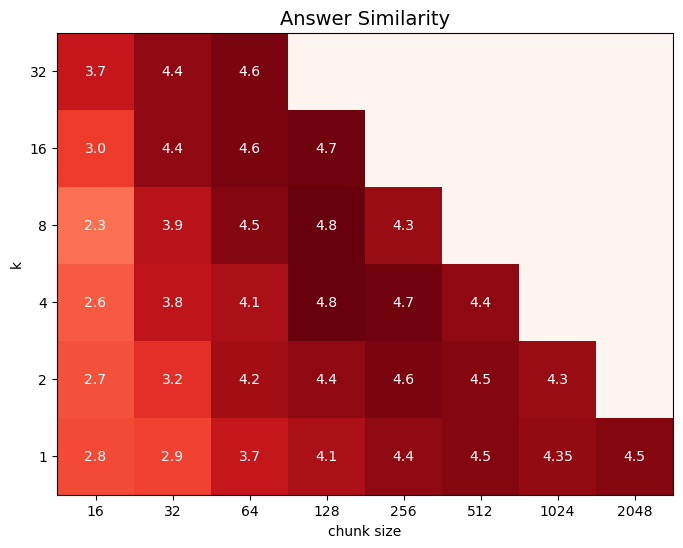

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
make_plot(score_df, "answer_similarity", ax)

Let's see an example of a question at chunk size 16 that is answered poorly when one context chunk is retrieved and answered well when more context chunks are retrieved.

For the question "What's the single biggest thing the government could do to increase the number of startups in this country?", the answer similarity score is 1.0 when 1 context chunks is retrieved and the score is 5.0 when 8 context chunks are retrieved.

In [11]:
ex_scores_1_context_chunk = pd.read_csv(
    "./sweep_response_scores/scores_df_chunk_size_32_similarity_top_k_1_evaluator_gpt-4.csv"
)
ex_scores_8_context_chunk = pd.read_csv(
    "./sweep_response_scores/scores_df_chunk_size_32_similarity_top_k_8_evaluator_gpt-4.csv"
)

In [12]:
ex_scores_1_context_chunk.iloc[[4]]

,question,reference_answer,llm_answer,retrieved_context,answer_similarity_score,retrieval_precision,augmentation_precision,augmentation_accuracy,answer_consistency,overall_score
4,What's the single biggest thing the government...,Establish a new class of visa for startup foun...,The government could provide more financial in...,['thing the government could do to increase th...,1.0,0.0,0.0,1.0,0.0,0.24


In [13]:
ex_scores_8_context_chunk.iloc[[4]]

,question,reference_answer,llm_answer,retrieved_context,answer_similarity_score,retrieval_precision,augmentation_precision,augmentation_accuracy,answer_consistency,overall_score
4,What's the single biggest thing the government...,Establish a new class of visa for startup foun...,The government could establish a new class of ...,['thing the government could do to increase th...,5.0,0.375,0.666667,0.625,1.0,0.733333


These are the respective answers and reference answer.

In [14]:
print(f"REFERENCE ANSWER: {ex_scores_1_context_chunk['reference_answer'].iloc[4]}\n")
print(f"ANSWER WITH 1 RETRIEVED CONTEXT CHUNK: {ex_scores_1_context_chunk['llm_answer'].iloc[4]}\n")
print(f"ANSWER WITH 8 RETRIEVED CONTEXT CHUNKS: {ex_scores_8_context_chunk['llm_answer'].iloc[4]}\n")

REFERENCE ANSWER: Establish a new class of visa for startup founders.

ANSWER WITH 1 RETRIEVED CONTEXT CHUNK: The government could provide more financial incentives and support for entrepreneurs and startups, such as tax breaks, grants, and access to funding. This would help alleviate some of the financial burdens and risks associated with starting a new business, making it more attractive for individuals to pursue entrepreneurial ventures. Additionally, the government could also invest in creating a favorable regulatory environment that promotes innovation and reduces barriers to entry for startups.

ANSWER WITH 8 RETRIEVED CONTEXT CHUNKS: The government could establish a new class of visa for startup founders. This would allow more startup founders to enter the country each year, which could have a visible effect on the economy and lead to a significant increase in the pool of startup founders. Additionally, the government could use investment by recognized startup investors as a tes

When 8 context chunks are retrieved, the answer gets the new class of visa context that is the correct context, while when only 1 context chunk is retrieved that does not end up in the answer. The answer is still coherent and looks good when only 1 context chunk is retrieved, which is one of the dangers of doing RAG without evaluating whether the correct context is being retrieved or not.

Let's see the retrieved context chunks.

In [15]:
ex_1_context_list = json.loads(
    convert_context_string(ex_scores_1_context_chunk["retrieved_context"].iloc[4])
)
ex_8_context_list = json.loads(
    convert_context_string(ex_scores_8_context_chunk["retrieved_context"].iloc[4])
)

print("CONTEXT WHEN 1 CONTEXT CHUNK IS RETRIEVED\n")
for i, x in enumerate(ex_1_context_list):
    print(f"CONTEXT CHUNK {i}: {x}\n")

print("CONTEXT WHEN 8 CONTEXT CHUNKS ARE RETRIEVED\n")
for i, x in enumerate(ex_8_context_list):
    print(f"CONTEXT CHUNK {i}: {x}\n")

CONTEXT WHEN 1 CONTEXT CHUNK IS RETRIEVED

CONTEXT CHUNK 0: thing the government could do to increase the number of startup

CONTEXT WHEN 8 CONTEXT CHUNKS ARE RETRIEVED

CONTEXT CHUNK 0: thing the government could do to increase the number of startups, and use investment by recognized startup investors as the test of whether a company was a real startup.How would the government decide who's a startup investor?, Letting just 10,000 startup founders into the country each year could have a visible effect on the economy., but would represent a huge increase in the pool of startup founders., The biggest constraint on the number of new startups that get created in the US is not tax policy or employment law or even Sarbanes-Oxley., establish a new class of visa for startup founders., The tricky part might seem to be how one defined a startup.But that could be solved quite easily: let the market decide., The time may soon be coming when instead of startups trying to seem more corporate, corpor

Because the context chunks are so short (16 tokens), context chunk 0 doesn't even make sense on it's own. When 8 context chunks are retrieved, we see the correct answer appearing in context chunk 5. The LLM driving the RAG query engine is able to take the 8 chunks and write a coherent answer, leading with the most relevant chunk stating that a new class of visa for startup founders should be established.

## Retrieval Precision

Retrieval precision is the percentage of retrieved context that is relevant to answering the question.

Retrieval precision has the property that as the number of chunks goes up, the percentage of relevant chunks to answer the question goes down. In the heatmap, we see a strong maximum when there is 1 retrieved chunk. The score of 1 when there is 1 retrieved chunk is commone because if there are relevant chunks to answer a question then when you retrieve one chunk it will likely be a relevant chunk. For chunk sizes 16 and 32 when one chunk is retrieved the scores are low because these chunks sizes are just too small. The text captured in chunks of size 16 or 32 tokens is not large enough to have information relevant to answer a question as we saw in the previous example.

Because the chunks have overlap in the query engines by design, even if there is truly only one section of relevant text in the documents, there could be more than 1 relevant context chunk because of the overlap. This explains why the retrieval precision scores are higher than one may intuitively have thought if there were only 1 relevant chunk.

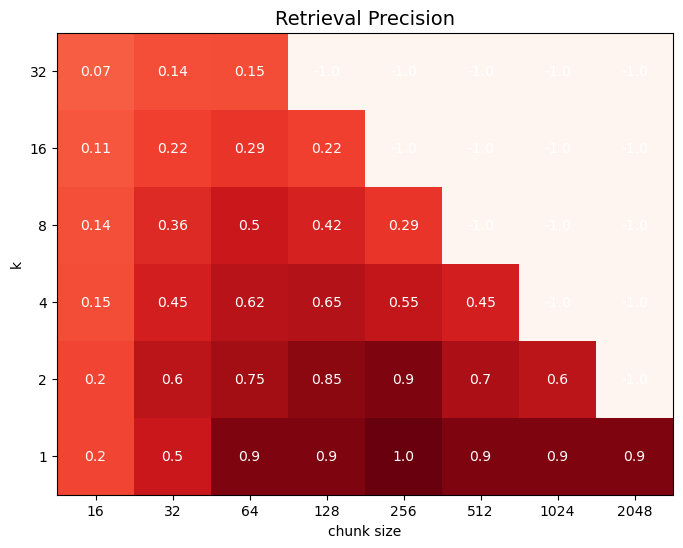

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
make_plot(score_df, "retrieval_precision", ax)

## Augmentation Precision

Augmentation precision is the percentage of relevant context chunks (as measured in retrieval precision), that end up in the RAG answer.

Augmentation precision is difficult to interpret. This heatmap has similar trends to the retrieval precision plot, but the values are all larger. The thing to note is that as the number of retrieved context chunks goes up, the number of chunks that are relevant also goes up (that is seen from the retrieval precision heatmap), but the percentage of those relevant chunks that ends up in the answer goes down. 

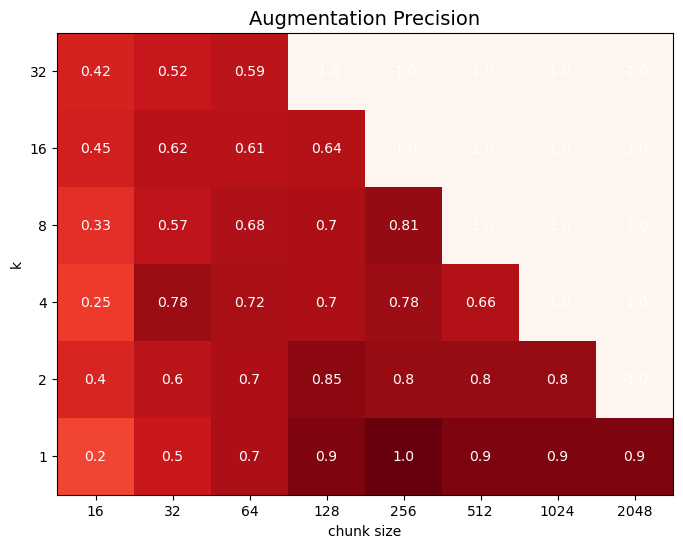

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
make_plot(score_df, "augmentation_precision", ax)

# Augmentation Accuracy

Augmentation accuracy is the percentage of retrieved chunks than end up in the answer.

As the number of retrieved context chunks goes up, augmentation accuracy decreases significantly faster than augmentation precision. This shows that the LLM is not putting irrelevant context into the answer. Augmentation accuracy should go down as the number of retrieved context vectors goes up, as we know that there are not a lot of truly relevant context chunks to retrieve for the questions.

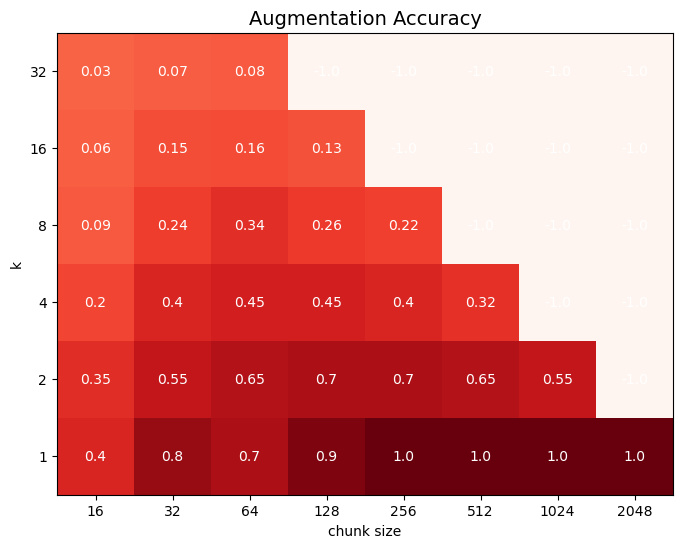

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
make_plot(score_df, "augmentation_accuracy", ax)

## Answer Consistency

Answer consistency is the percentage of main points in the answer that can be attributed to retrieved context.

Answer consistency goes up as the number of retrieved context chunks goes up. This makes sense, as when there is more retrieved context in the LLM prompt, the answer is more likely to consist of points from the retrieved chunks. What is interesting here is that as the chunk size goes up the answer consistency also goes up. This is particularly dramatic when the number of retrieved chunks is 1, 2, and 4 where there are a significant number of different chunk sizes. This shows numerically what is intuitively true that for larger chunks there is more coherent content (less likely to have fragments of thoughts) that the LLM can pull from to fill up the answer.

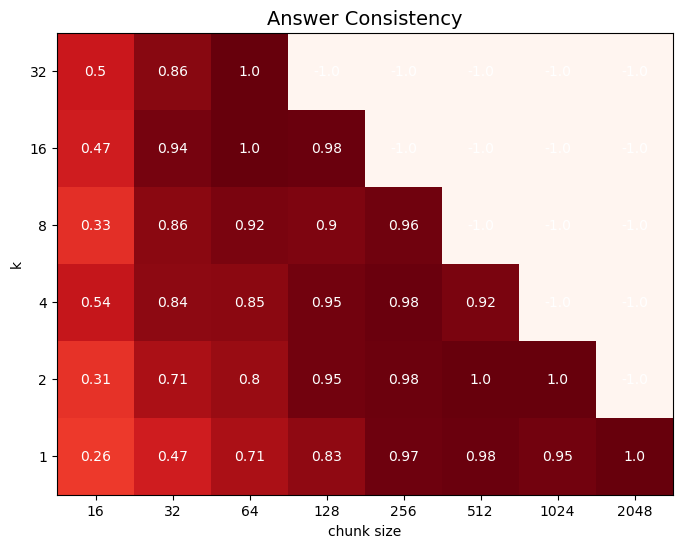

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
make_plot(score_df, "answer_consistency", ax)

## Overall Score

The overall score is the average of the other scores.

The overall score shows that chunk size 256 and number of retrieved context of 1 is the best combination of parameters. The heatmap is coherent in the sense that there is a parabolic shape trending up towards the best parameters where all the highest scores are clumped together. This shows that choices of parameters near the optimal one would also be good choices and may be what one would want to choice. You may not want to only have one retrieved context vector because you know that some answers will need more than one pieve of retrieved context and you do not want to automatically get those questions wrong off the bat.

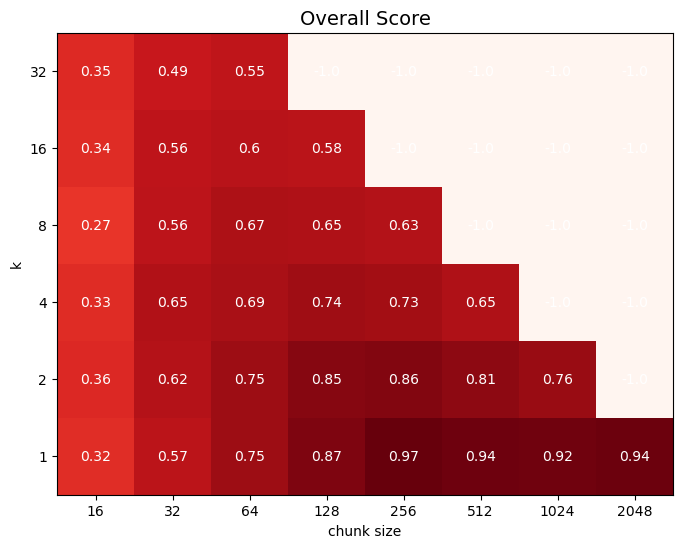

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
make_plot(score_df, "overall_score", ax)

Let's look at the answer to the previous example question we get when we use these best parameters.

In [21]:
ex_scores_chunk_size_256 = pd.read_csv(
    "./sweep_response_scores/scores_df_chunk_size_256_similarity_top_k_1_evaluator_gpt-4.csv"
)

context_chunk = json.loads(
    convert_context_string(ex_scores_chunk_size_256["retrieved_context"].iloc[4])
)[0]

print(f"QUESTION: {ex_scores_chunk_size_256['question'].iloc[4]}\n")
print(f"REFERENCE ANSWER: {ex_scores_chunk_size_256['reference_answer'].iloc[4]}\n")
print(f"RAG ANSWER: {ex_scores_chunk_size_256['llm_answer'].iloc[4]}\n")
print(f"RETRIEVED CONTEXT CHUNK: {context_chunk}\n")

QUESTION: What's the single biggest thing the government could do to increase the number of startups in this country?

REFERENCE ANSWER: Establish a new class of visa for startup founders.

RAG ANSWER: Establish a new class of visa for startup founders.

RETRIEVED CONTEXT CHUNK: The Founder Visa

April 2009

I usually avoid politics, but since we now seem to have an administration that's open to suggestions, I'm going to risk making one.The single biggest thing the government could do to increase the number of startups in this country is a policy that would cost nothing: establish a new class of visa for startup founders.The biggest constraint on the number of new startups that get created in the US is not tax policy or employment law or even Sarbanes-Oxley.It's that we won't let the people who want to start them into the country.Letting just 10,000 startup founders into the country each year could have a visible effect on the economy.If we assume 4 people per startup, which is probabl

Amusingly, the RAG answer is exactly the same as the reference answer. You can also see from the retrieved context chunk that the wording of the question and the wording of the answer are taken directly from the context chunk. (The context chunk contains the string "The single biggest thing the government could do to increase the number of startups in this country is a policy that would cost nothing: establish a new class of visa for startup founders.") The LLM in the RAG query engine recognizes the question and answer in the context chunk and pulls out the exact answer. This is possible in part because the context chunk is large enough to contain the question and answer. 

# Appendix

In this appendix, we show the line plots of each score with k on the x-axis with the chunk size fixed and the line plots of each score with the chunk size on the x-axis with k fixed. The heatmaps show all three of the chunk size, k, and score at once, but these 2-d plots are included for completeness for those interested in seeing in a different visual way the relationships shown in the heatmaps.

In [22]:
def log_base_2(x: int):
    ans = 0
    while x // 2 > 0:
        ans += 1
        x = x // 2
    return ans

In [23]:
score_names = [
    "answer_similarity",
    "retrieval_precision",
    "augmentation_precision",
    "augmentation_accuracy",
    "answer_consistency",
    "overall_score"
]

How each score changes with respect to k, when the chunk size is fixed.

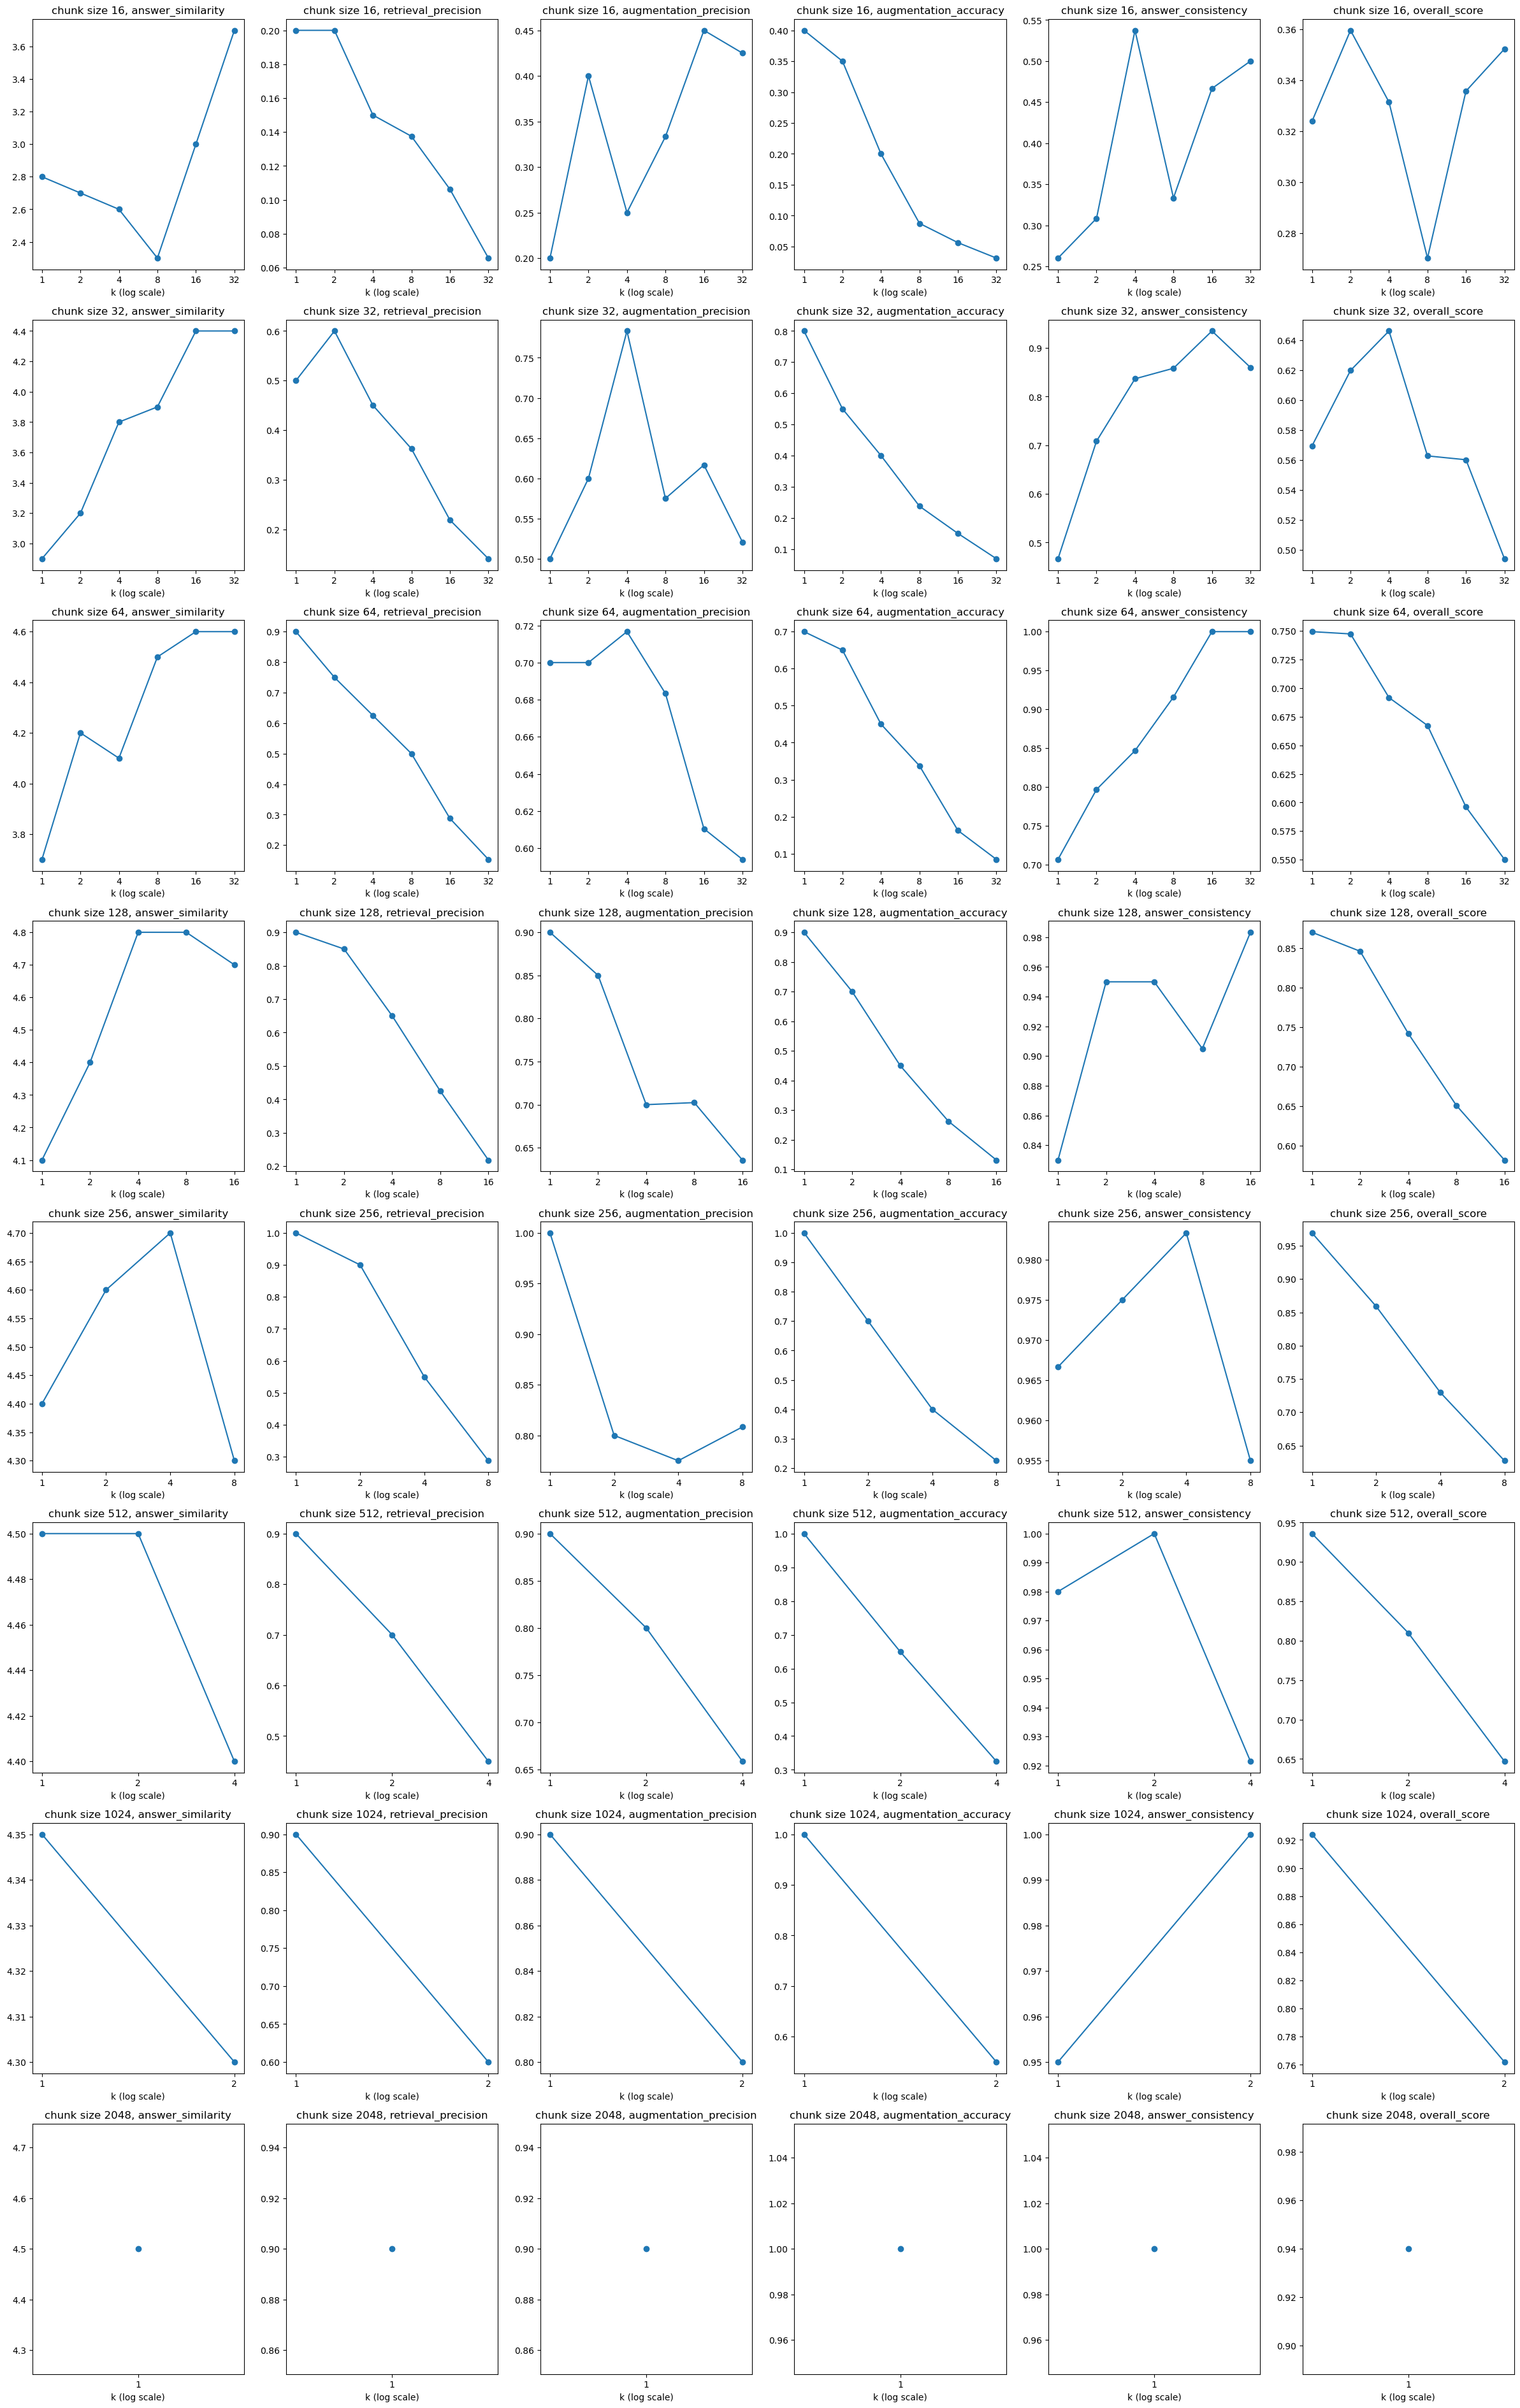

In [24]:
fig, axs = plt.subplots(score_df["chunk_size"].nunique(), len(score_names), figsize=(30, 48))
y_plot_index = 0
for chunk_size, gp in score_df.groupby("chunk_size"):
    gp_sorted = gp.sort_values(by="similarity_top_k")
    x_plot_index = 0
    x = [log_base_2(x) for x in list(gp_sorted["similarity_top_k"])]
    x_ticks = x
    x_labels = list(gp_sorted["similarity_top_k"])
    for col in score_names:
        y = list(gp_sorted[col])
        ax = axs[y_plot_index, x_plot_index]
        ax.plot(x, y, '-o')
        ax.set_title(f"chunk size {chunk_size}, {col}")
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_xlabel("k (log scale)")
        
        x_plot_index += 1
    y_plot_index += 1

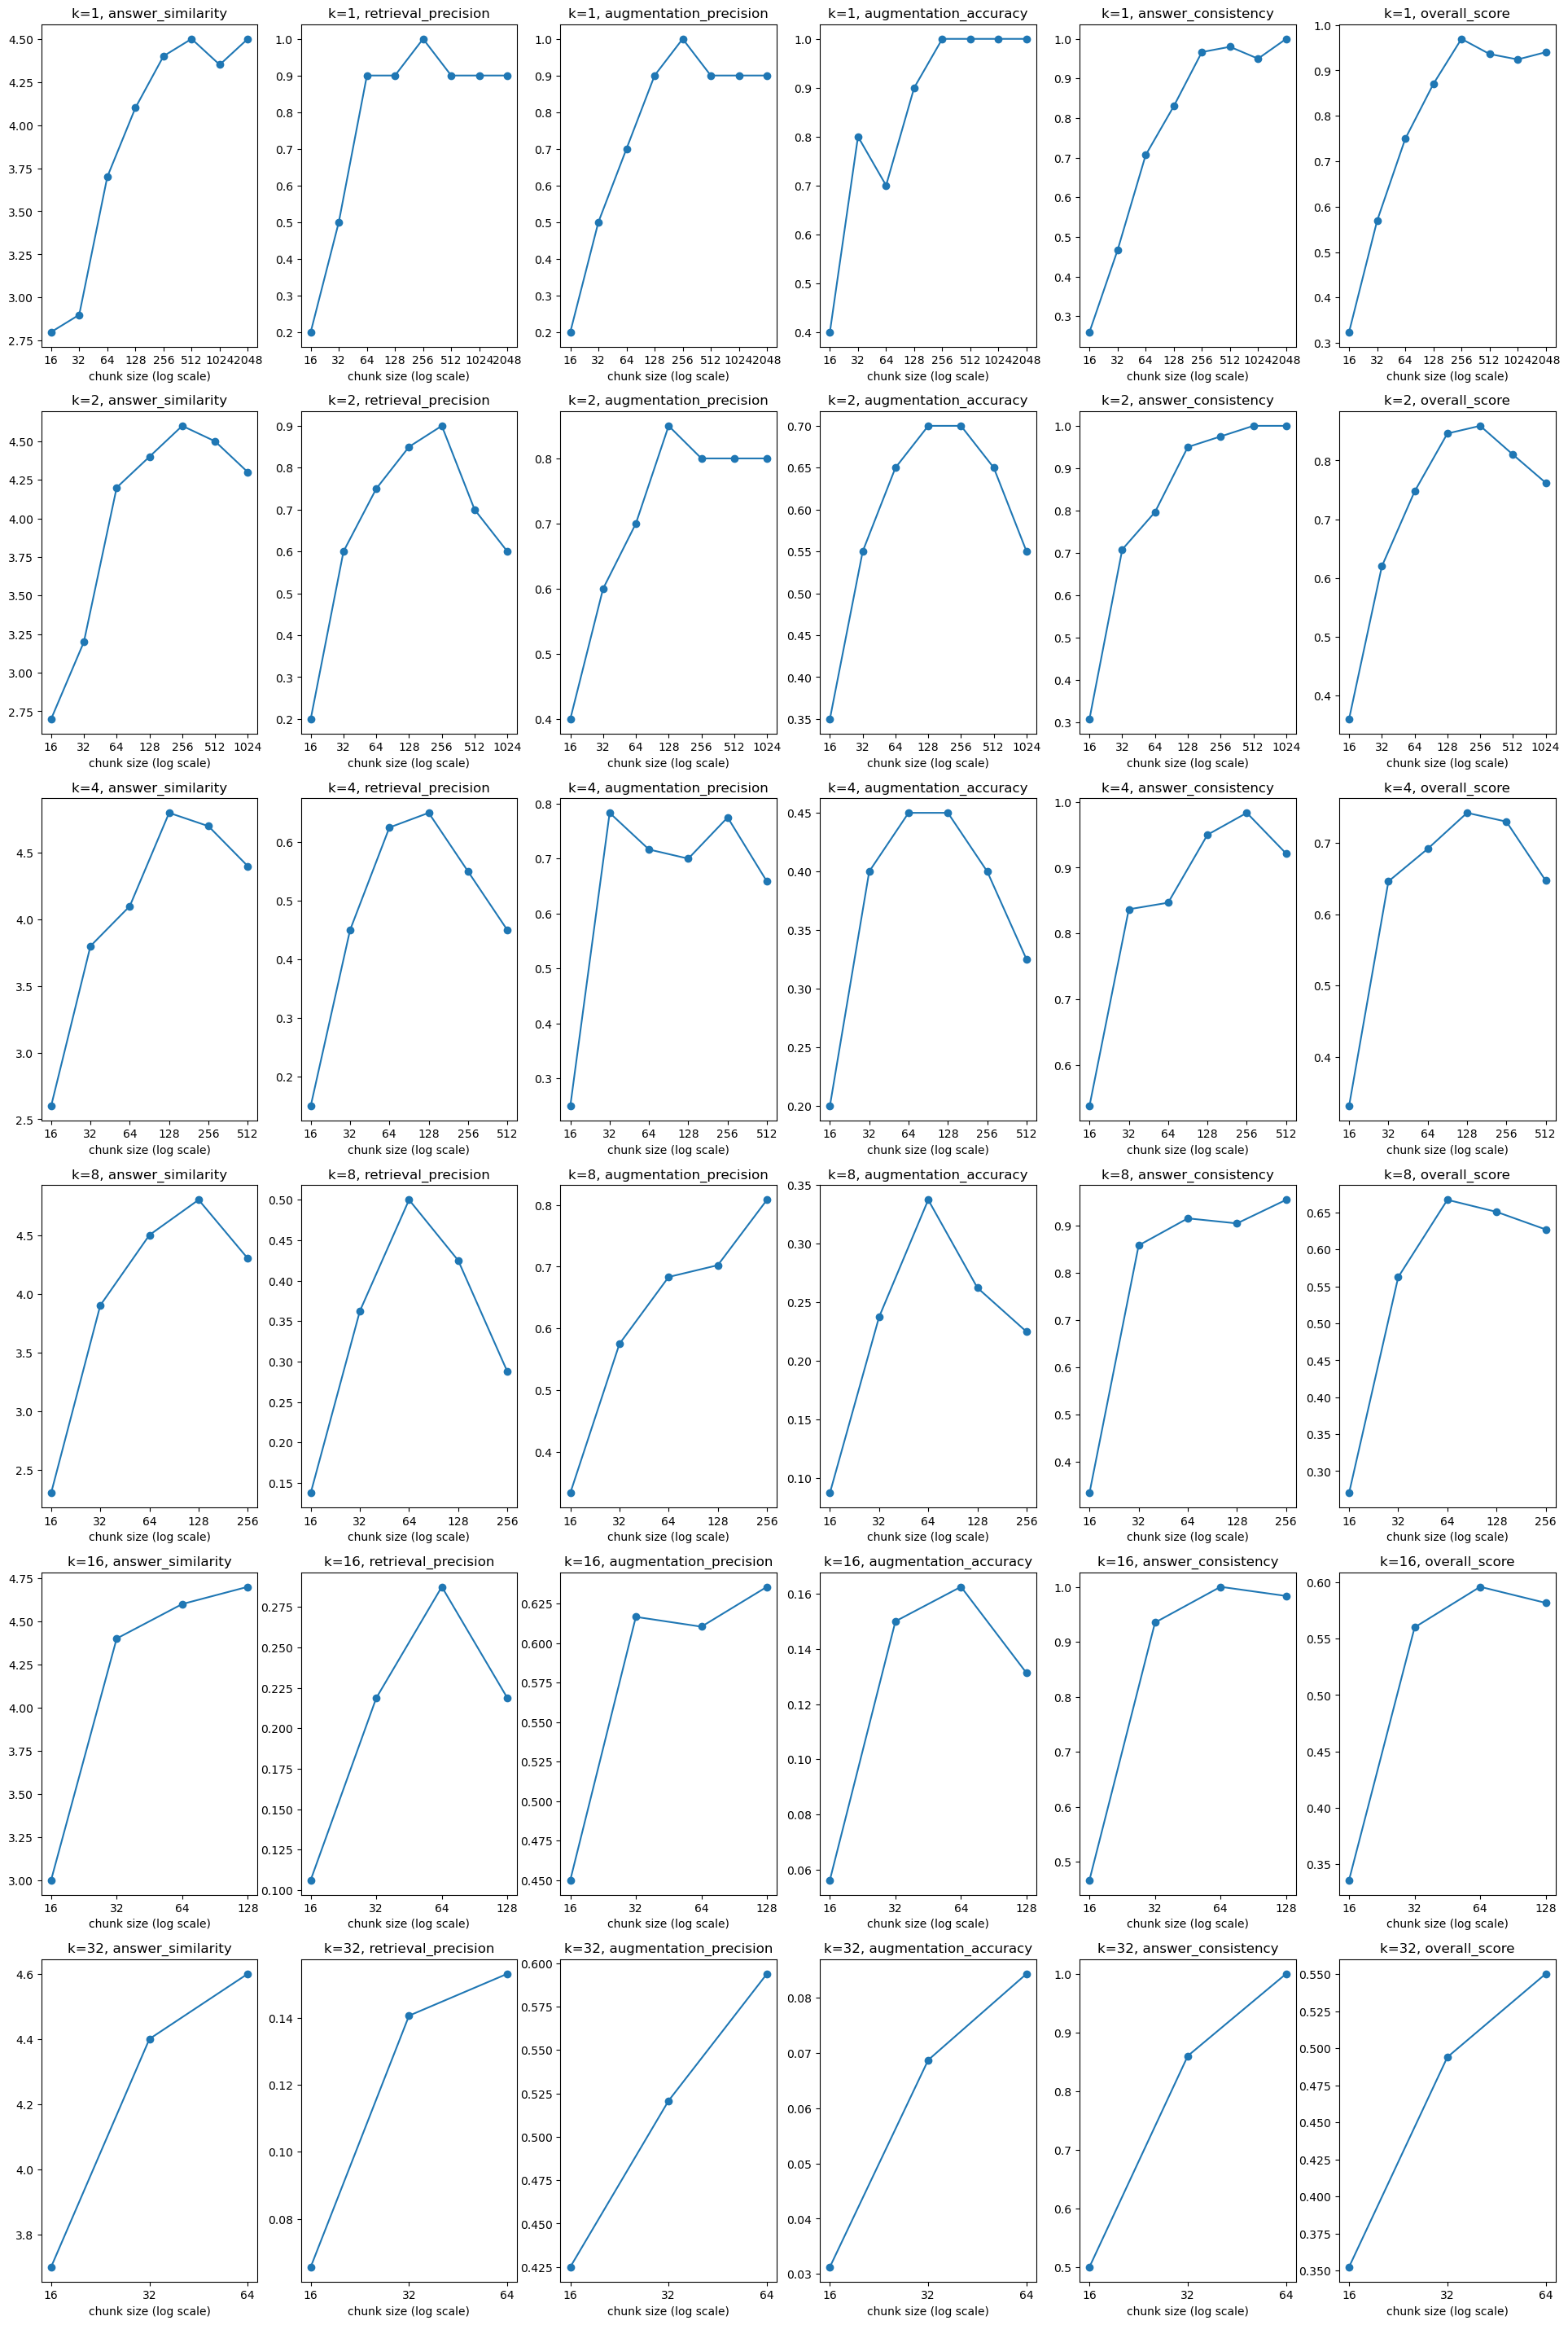

In [25]:
fig, axs = plt.subplots(score_df["similarity_top_k"].nunique(), len(score_names), figsize=(24, 36))
y_plot_index = 0
for similarity_top_k, gp in score_df.groupby("similarity_top_k"):
    x_plot_index = 0
    gp_sorted = gp.sort_values(by="chunk_size")
    x = [log_base_2(x) for x in list(gp_sorted["chunk_size"])]
    x_ticks = x
    x_labels = list(gp_sorted["chunk_size"])
    for col in score_names:
        y = list(gp_sorted[col])
        ax = axs[y_plot_index, x_plot_index]
        ax.plot(x, y, '-o')
        ax.set_title(f"k={similarity_top_k}, {col}")
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_xlabel("chunk size (log scale)")
        
        x_plot_index += 1
    y_plot_index += 1